* Name: `dissipation-theory--Study-14.ipynb`
* Author: John A. Marohn
* Date: 2023-12-01
* Continued from: `dissipation-theory--Study-12.ipynb`
* Continued to: ---
* Summary: Calculate dissipation $\gamma_{\perp}$ versus charge density $\rho$ for a representive perovskite sample.

Compare the exact result to the low-density exapansion and an analytical expression for $\gamma_{\perp}^{\mathrm{max}}$.  Both these approximations are only valid in the infinite-sample limit, so use Model 2 with the dielectric overlayer thickness set to zero.  Compare the infinite-sample Model 2 result to a finite-sample Model 1 result, to check the validity of the infinite-sample approximation used to obtain an analytical result for the height dependence of the $\gamma_{\perp}$.

# Preliminaries

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation import CantileverModel, SampleModel2
from dissipationtheory.dissipation import CantileverModelJit, SampleModel2Jit
from dissipationtheory.dissipation import theta2norm_jit, gamma_perpendicular_jit, gamma_perpendicular_approx

In [7]:
from dissipationtheory.constants import epsilon0
from dissipationtheory.capacitance import Csphere, CsphereOverSemi

In [8]:
THIS = 'dissipation-theory--Study-14'

# Infinitely thick sample

In [53]:
hd = ureg.Quantity(0., 'nanometer')   # no dielectric overlayer
epsilond = complex(1., 0.)            # doesn't matter since hd = 0
epsilons = complex(26., 0.)           # Frost2014may, assume only real part
rho = ureg.Quantity(1e15,'cm^{-3}')   # 1e13 to 1e16 (1 to 1000 mW/cm^2)) -- Kim2018may Figure S9
mu = ureg.Quantity(8e-4, 'cm^2/(s V)')  # Kim2018may Figure S9; 8 cm^2/Vs

fc = ureg.Quantity(75, 'kHz')       # measured
Vts = ureg.Quantity(1, 'volt')      # measured
r = ureg.Quantity(30, 'nanometer')  # spec
h = ureg.Quantity(40, 'nanometer')  # measured

The associated conductivity is

In [54]:
sigma = (qe * mu * rho).to('S/m')
print('conductivity = {:+.2e~P}'.format(sigma.to('S/cm')))

conductivity = +1.28e-07 S/cm


Set up a Model 2 experiment.  We need two version of the sample model -- the jit version for the fast numerical computation and the regular version for the analytical approximation.

In [63]:
sample2_jit = SampleModel2Jit(
    cantilever=CantileverModelJit(
        fc.to('Hz').magnitude, 
        Vts.to('V').magnitude,  
        r.to('m').magnitude, 
        h.to('m').magnitude), 
    epsilon_d=epsilond,
    h_d=hd.to('m').magnitude,
    epsilon_s=epsilons,
    mu=mu.to('m^2/(s V)').magnitude,
    rho=rho.to('m^{-3}').magnitude,
    z_r=h.to('m').magnitude)

In [64]:
sample2 = SampleModel2(
    cantilever=CantileverModel(fc, Vts, r, h),
    epsilon_d=ureg.Quantity(epsilond,''),
    h_d=hd,
    epsilon_s=ureg.Quantity(epsilons,''),
    mu=mu,
    rho=rho,
    z_r=h)

Simulate friction versus charge density.

In [65]:
rho_= ureg.Quantity(np.logspace(start=11, stop=16, num=50), '1/cm^3')
sigma_ = (qe * mu * rho_).to('1/(ohm m)')

In [66]:
%%time
result1 = {
    'rho': rho_,
    'sigma': sigma_,
    'gamma': ureg.Quantity(np.zeros_like(rho_), 'pN s/m')
}

for index, rho__ in enumerate(rho_):

        sample2_jit.rho = rho__.to('1/m^3').magnitude
        result1['gamma'][index] = gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')

CPU times: user 554 ms, sys: 18.1 ms, total: 572 ms
Wall time: 811 ms


Compute the low-density approximation.

In [67]:
gamma_perpendicular_approx(rho_, sample2)

(array([1.00000000e+17, 1.26485522e+17, 1.59985872e+17, 2.02358965e+17,
        2.55954792e+17, 3.23745754e+17, 4.09491506e+17, 5.17947468e+17,
        6.55128557e+17, 8.28642773e+17, 1.04811313e+18, 1.32571137e+18,
        1.67683294e+18, 2.12095089e+18, 2.68269580e+18, 3.39322177e+18,
        4.29193426e+18, 5.42867544e+18, 6.86648845e+18, 8.68511374e+18,
        1.09854114e+19, 1.38949549e+19, 1.75751062e+19, 2.22299648e+19,
        2.81176870e+19, 3.55648031e+19, 4.49843267e+19, 5.68986603e+19,
        7.19685673e+19, 9.10298178e+19, 1.15139540e+20, 1.45634848e+20,
        1.84206997e+20, 2.32995181e+20, 2.94705170e+20, 3.72759372e+20,
        4.71486636e+20, 5.96362332e+20, 7.54312006e+20, 9.54095476e+20,
        1.20679264e+21, 1.52641797e+21, 1.93069773e+21, 2.44205309e+21,
        3.08884360e+21, 3.90693994e+21, 4.94171336e+21, 6.25055193e+21,
        7.90604321e+21]) <Unit('1 / meter ** 3')>,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0

Why are the arrays empty?  Check the critical density; maybe we are below it.  Steal, then modify, the following code fragment from the definition of `gamma_perpendicular_approx`.

In [68]:
rho_x = ((sample2.cantilever.omega_c * epsilon0)/(qe * sample2.mu)).to('1/m^3').magnitude
r2  = ((sample2.epsilon_s.real**2 
    + sample2.epsilon_s.imag**2)/sample2.epsilon_s.real).to('dimensionless').magnitude
rho2crit = r2 * rho_x

In [69]:
rho2crit

8.463750061546535e+21

Plot the friction versus charge density.

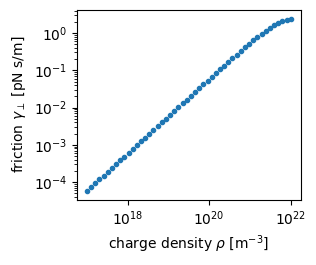

In [70]:
fig = plt.figure(figsize=(3.25, 2.75))

plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.')

x,y = gamma_perpendicular_approx(rho_, sample2)
plt.loglog(
    x.to('1/m^3').magnitude,
    y.to('pN s/m').magnitude,
    '-')

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1.png', dpi=300)
plt.savefig(THIS + '--Fig-1.pdf')

plt.show()